In [1]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]

data = data.iloc[:3524]
data_copy = data.copy()

print('Data imported and copied.', flush=True)

Data imported and copied.


In [2]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

period = 60
trend_period = 14
rsi_period = 14
num_features = 3
input_period = 46
output_step = 7
units = 512

In [3]:
X, y = create_dataset(data[['close']].to_numpy(), time_step=period, output_step=output_step)

In [4]:
data_input = np.array([np.concatenate((X[i], y[i]), axis=0) for i in range(X.shape[0])])

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions = np.array([seasonal_decompose(data_input[i], model='additive', period=14) for i in range(data_input.shape[0])])
seasons = np.array([decompositions[i].seasonal for i in range(decompositions.shape[0])])

In [6]:
seasons[0].shape

(67,)

In [7]:
from talib import RSI

rsi = np.array([ RSI(data_input[i]) for i in range(data_input.shape[0]) ])

In [8]:
import statsmodels.api as sm

smoothing_lowess = sm.nonparametric.lowess
lowess = np.array([ smoothing_lowess(data_input[i], range(67), frac=0.1)[:, 1] for i in range(data_input.shape[0]) ])

In [9]:
lowess[0], seasons[0], rsi[0][14:].shape

(array([1469.83127383, 1486.08042802, 1502.38200229, 1513.87736816,
        1521.6696923 , 1527.60654485, 1529.29796059, 1531.16591785,
        1533.58204469, 1539.45390194, 1545.15626346, 1547.15465098,
        1543.30535997, 1537.86879845, 1533.79288311, 1526.26421805,
        1517.01852219, 1505.4945353 , 1496.19124787, 1492.36064696,
        1488.6097079 , 1480.84013804, 1477.15674001, 1478.48848494,
        1484.23916262, 1494.68583164, 1500.96859198, 1501.9453653 ,
        1501.08133951, 1500.47338819, 1498.96083651, 1496.78588876,
        1489.89773426, 1478.59265708, 1470.87986843, 1468.18179144,
        1469.29936691, 1473.29312688, 1476.92990006, 1476.35806755,
        1475.66370839, 1474.58825138, 1470.21537846, 1462.52861476,
        1450.04902223, 1433.35861821, 1421.76391573, 1415.66331438,
        1410.39229636, 1411.12909959, 1412.98170223, 1413.71210332,
        1410.49816882, 1399.25041094, 1386.64286212, 1384.06091534,
        1392.50300235, 1406.42489564, 1423.43945

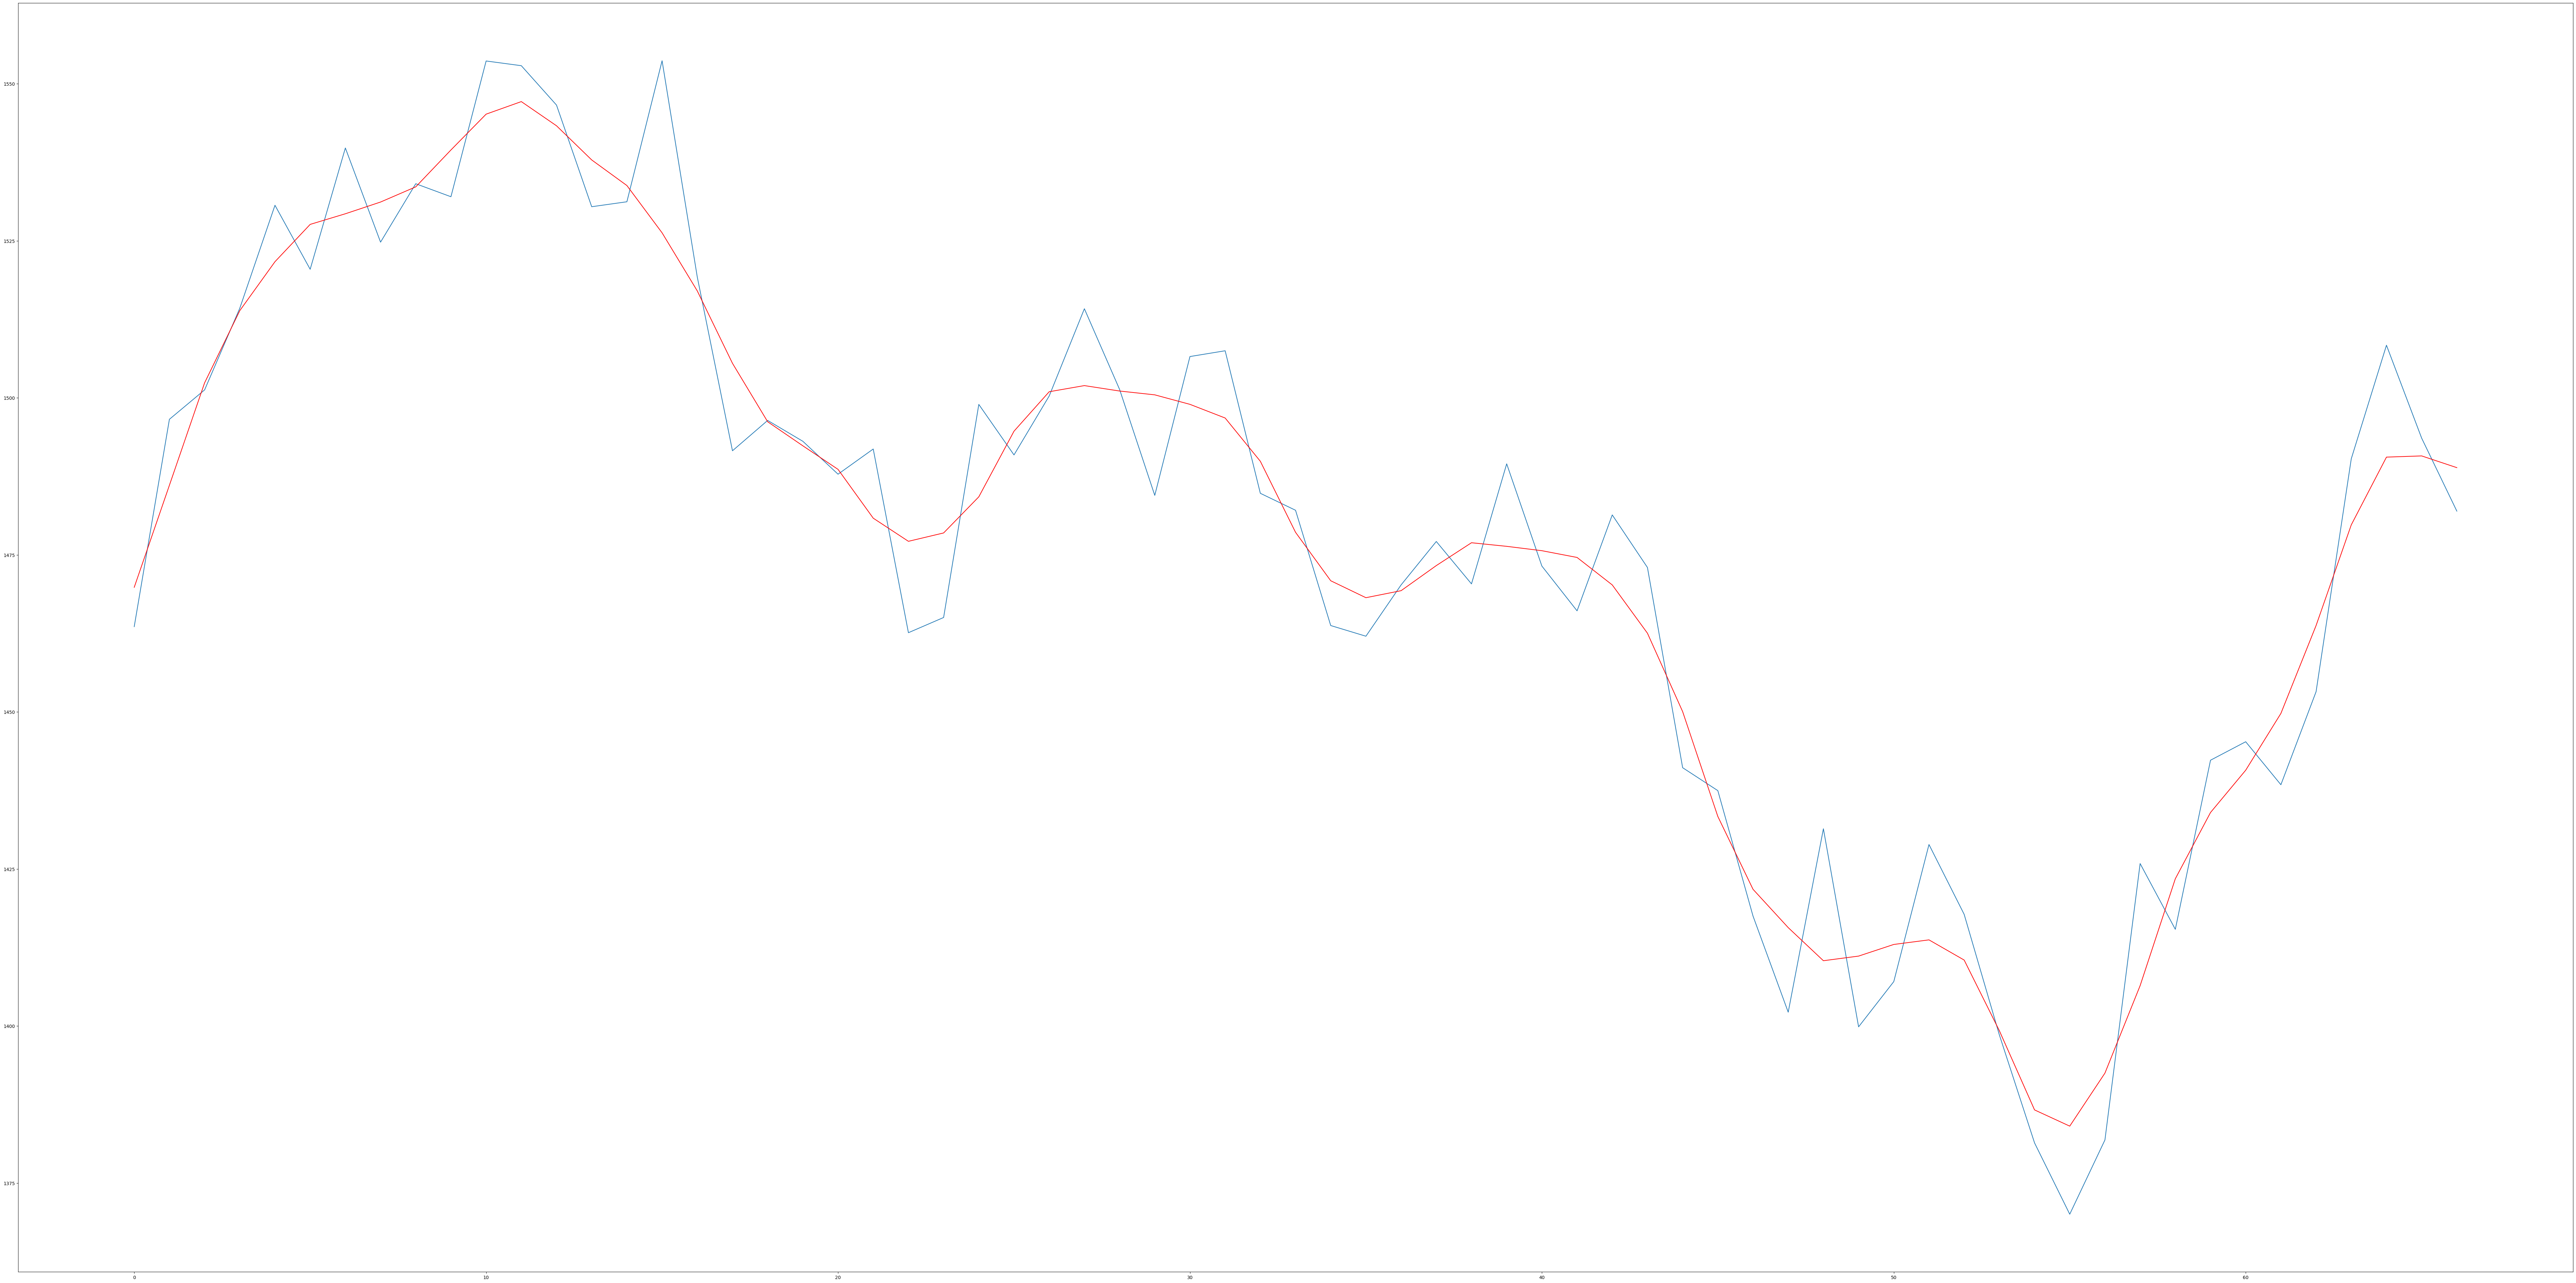

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 50))

plt.plot(data_input[0], label='Original Data')
plt.plot(lowess[0], label='Lowess Smoothing', color='red')

In [11]:
y.shape

(3457, 7)

In [12]:
lowess_cropped = list()
seasons_cropped = list()
rsi_dropna = list()

for _lowess in lowess:
    #lowess_cropped.append(_lowess[rsi_period:-y.shape[1]])
    lowess_cropped.append(_lowess[rsi_period:])

for _season in seasons:
    #seasons_cropped.append(_season[rsi_period:-y.shape[1]])
    seasons_cropped.append(_season[rsi_period:])

for _rsi in rsi:
    #rsi_dropna.append(_rsi[rsi_period:-y.shape[1]])
    rsi_dropna.append(_rsi[rsi_period:])

lowess_cropped = np.array(lowess_cropped)
seasons_cropped = np.array(seasons_cropped)
rsi_dropna = np.array(rsi_dropna)

In [13]:
lowess_cropped.shape, seasons_cropped.shape, rsi_dropna.shape

((3457, 53), (3457, 53), (3457, 53))

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler_lowess = list(MinMaxScaler() for i in range(lowess_cropped.shape[0]))
lowess_scaled = list()

scaler_seasonal = list(MinMaxScaler() for i in range(seasons_cropped.shape[0]))
seasons_scaled = list()

scaler_rsi = list(MinMaxScaler() for i in range(rsi_dropna.shape[0]))
rsi_scaled = list()

for i in range(lowess_cropped.shape[0]):
    lowess_scaled.append(scaler_lowess[i].fit_transform(lowess_cropped[i].reshape(-1,1)))

for i in range(seasons_cropped.shape[0]):
    seasons_scaled.append(scaler_seasonal[i].fit_transform(seasons_cropped[i].reshape(-1,1)))

for i in range(rsi_dropna.shape[0]):
    rsi_scaled.append(scaler_rsi[i].fit_transform(rsi_dropna[i].reshape(-1,1)))

lowess_scaled = np.array(lowess_scaled)
seasons_scaled = np.array(seasons_scaled)
rsi_scaled = np.array(rsi_scaled)

In [15]:
X_input = list()
y_input = list()

for lowess, season, rsi in zip(lowess_scaled, seasons_scaled, rsi_scaled):
    X_input.append(np.hstack((lowess[:-y.shape[1]], season[:-y.shape[1]], rsi[:-y.shape[1]])))
    y_input.append(lowess[-y.shape[1]:])

X_input = np.array(X_input)
y_input = np.array(y_input)

In [16]:
X_input.shape

(3457, 46, 3)

# Main model

In [17]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Conv1D, AveragePooling1D, Flatten, Reshape, SimpleRNN, GRU, MaxPooling1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Zeros

inputs = Input(shape=(input_period, num_features))

model_cnn = Sequential([
    Conv1D(filters=352, kernel_size=1, activation='relu'),
    Conv1D(filters=352, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dense(units=128),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bilstm = Sequential([
    Bidirectional(LSTM(units=384, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')),
    Dropout(0.2),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bigru = Sequential([
    Bidirectional(GRU(units=128, activation='tanh', return_sequences=True)),
    Dropout(0.4),
    Flatten()
])

model_multilayer_lstm = Sequential([
    LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Dropout(0.2),
    LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Flatten()
])

2024-06-13 06:12:19.948420: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 06:12:20.310723: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 06:12:20.311072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 06:12:20.368713: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 06:12:20.409375: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 06:12:22.597863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [18]:
output_cnn = model_cnn(inputs)
output_bilstm = model_bilstm(inputs)
output_bigru = model_bigru(inputs)
output_multilayer_lstm = model_multilayer_lstm(inputs)

concatenated_outputs = concatenate([output_cnn, output_bilstm, output_bigru, output_multilayer_lstm])

main_model = Sequential([
    Input(shape=(concatenated_outputs.shape[1],)),
    Dense(units=output_step),
    Reshape((output_step,1))
])

final_output = main_model(concatenated_outputs)

functional_pipeline = Model(inputs=inputs, outputs=final_output)

In [30]:
# Compile the pipeline model
functional_pipeline.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='model_weights_6_4_main/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the pipeline model
history = functional_pipeline.fit(X_input, y_input, epochs=150, batch_size=64, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/150
44/44 [==============================] - 64s 1s/step - loss: 0.1637 - accuracy: 0.0633 - val_loss: 0.0442 - val_accuracy: 0.0766
Epoch 2/150
44/44 [==============================] - 48s 1s/step - loss: 0.0416 - accuracy: 0.0749 - val_loss: 0.0330 - val_accuracy: 0.0801
Epoch 3/150
44/44 [==============================] - 49s 1s/step - loss: 0.0352 - accuracy: 0.0765 - val_loss: 0.0310 - val_accuracy: 0.0815
Epoch 4/150
44/44 [==============================] - 54s 1s/step - loss: 0.0292 - accuracy: 0.0778 - val_loss: 0.0303 - val_accuracy: 0.0828
Epoch 5/150
44/44 [==============================] - 51s 1s/step - loss: 0.0266 - accuracy: 0.0783 - val_loss: 0.0395 - val_accuracy: 0.0801
Epoch 6/150
44/44 [==============================] - 53s 1s/step - loss: 0.0261 - accuracy: 0.0789 - val_loss: 0.0277 - val_accuracy: 0.0830
Epoch 7/150
44/44 [==============================] - 50s 1s/step - loss: 0.0245 - accuracy: 0.0789 - val_loss: 0.0281 - val_accuracy: 0.0822
Epoch 8/150
4

In [31]:
# Select the epoch
best_epoch = np.argmin(history.history['val_loss'])
best_epoch = best_epoch+1
print(f'best result is for epoch number {best_epoch}')

# Load the weights of the model at the chosen epoch
functional_pipeline.load_weights(f'model_weights_6_4_main/model_weights_epoch_{best_epoch:02d}.h5')
print('Weigths for the best epoch has been loaded.')

best result is for epoch number 6
Weigths for the best epoch has been loaded.


In [19]:
best_epoch_backup = 6

# Load the weights of the model at the chosen epoch
functional_pipeline.load_weights(f'model_weights_6_4_main/model_weights_epoch_{best_epoch_backup:02d}.h5')
print('Backup: Weigths for the best epoch has been loaded.')

Backup: Weigths for the best epoch has been loaded.


### **smoothing methods**

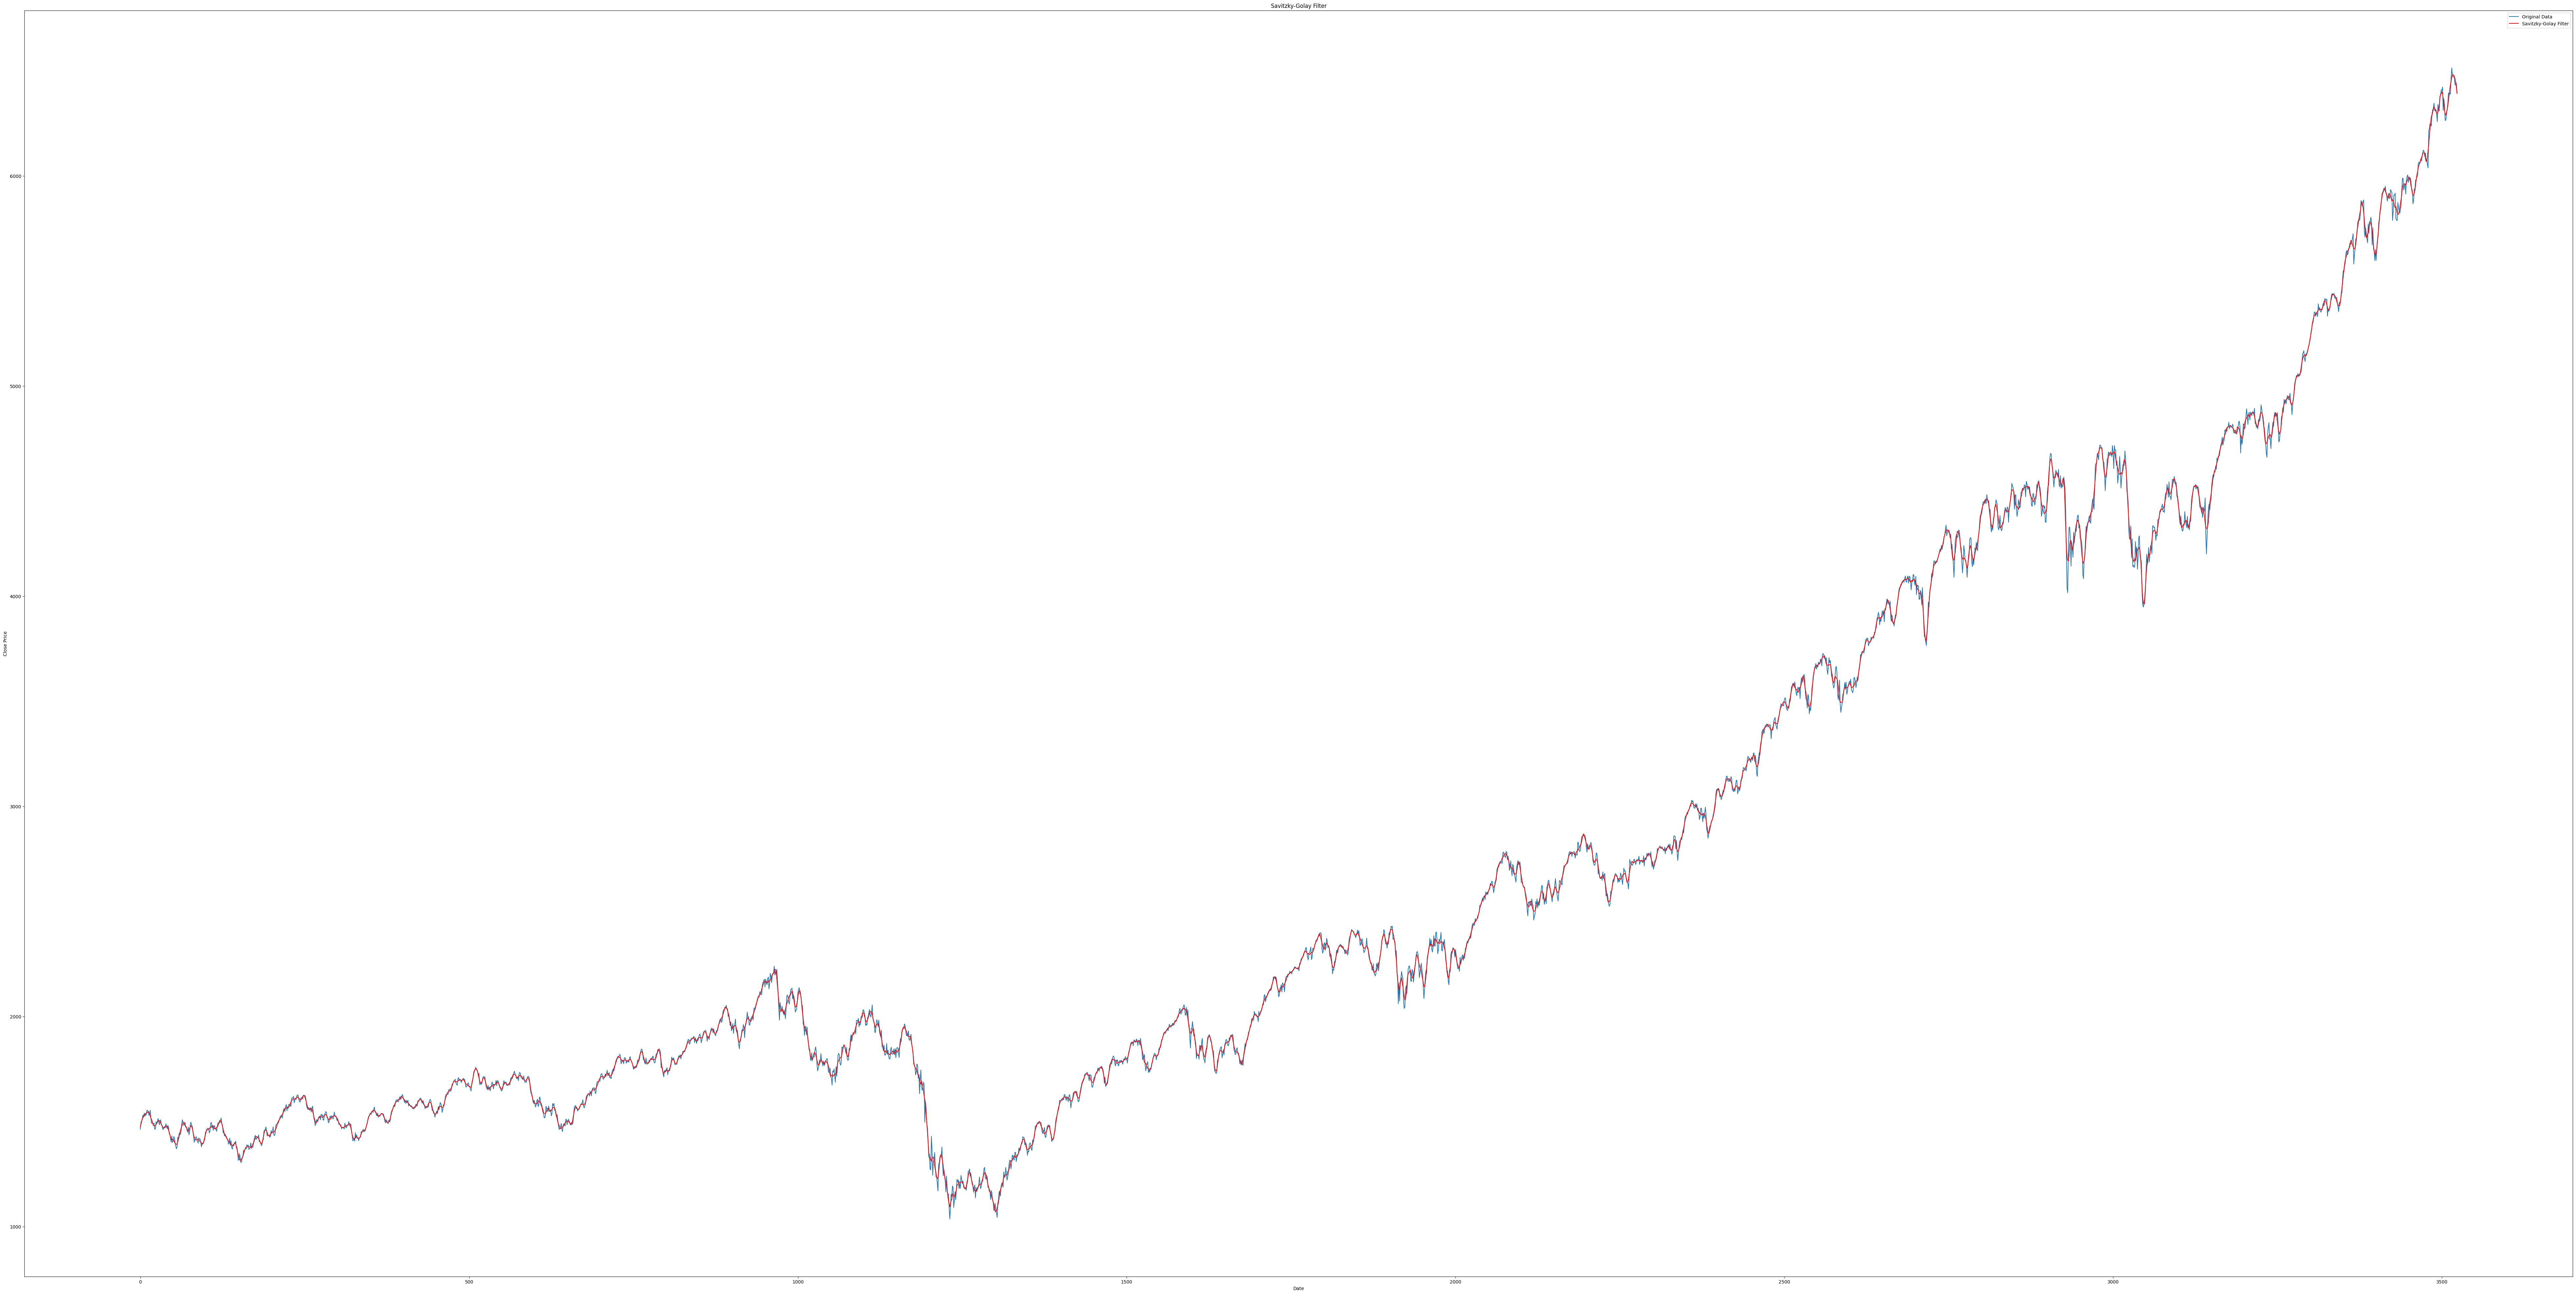

In [20]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(100, 50))

df = data_copy.copy()
# Apply Savitzky-Golay filter
window_length = 11  # Window length (must be odd)
polyorder = 2      # Polynomial order
df['SG'] = savgol_filter(df['close'], window_length, polyorder)

# Plot the original and smoothed data

plt.plot(df['close'], label='Original Data')
plt.plot(df['SG'], label='Savitzky-Golay Filter', color='red')
plt.legend()
plt.title('Savitzky-Golay Filter')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


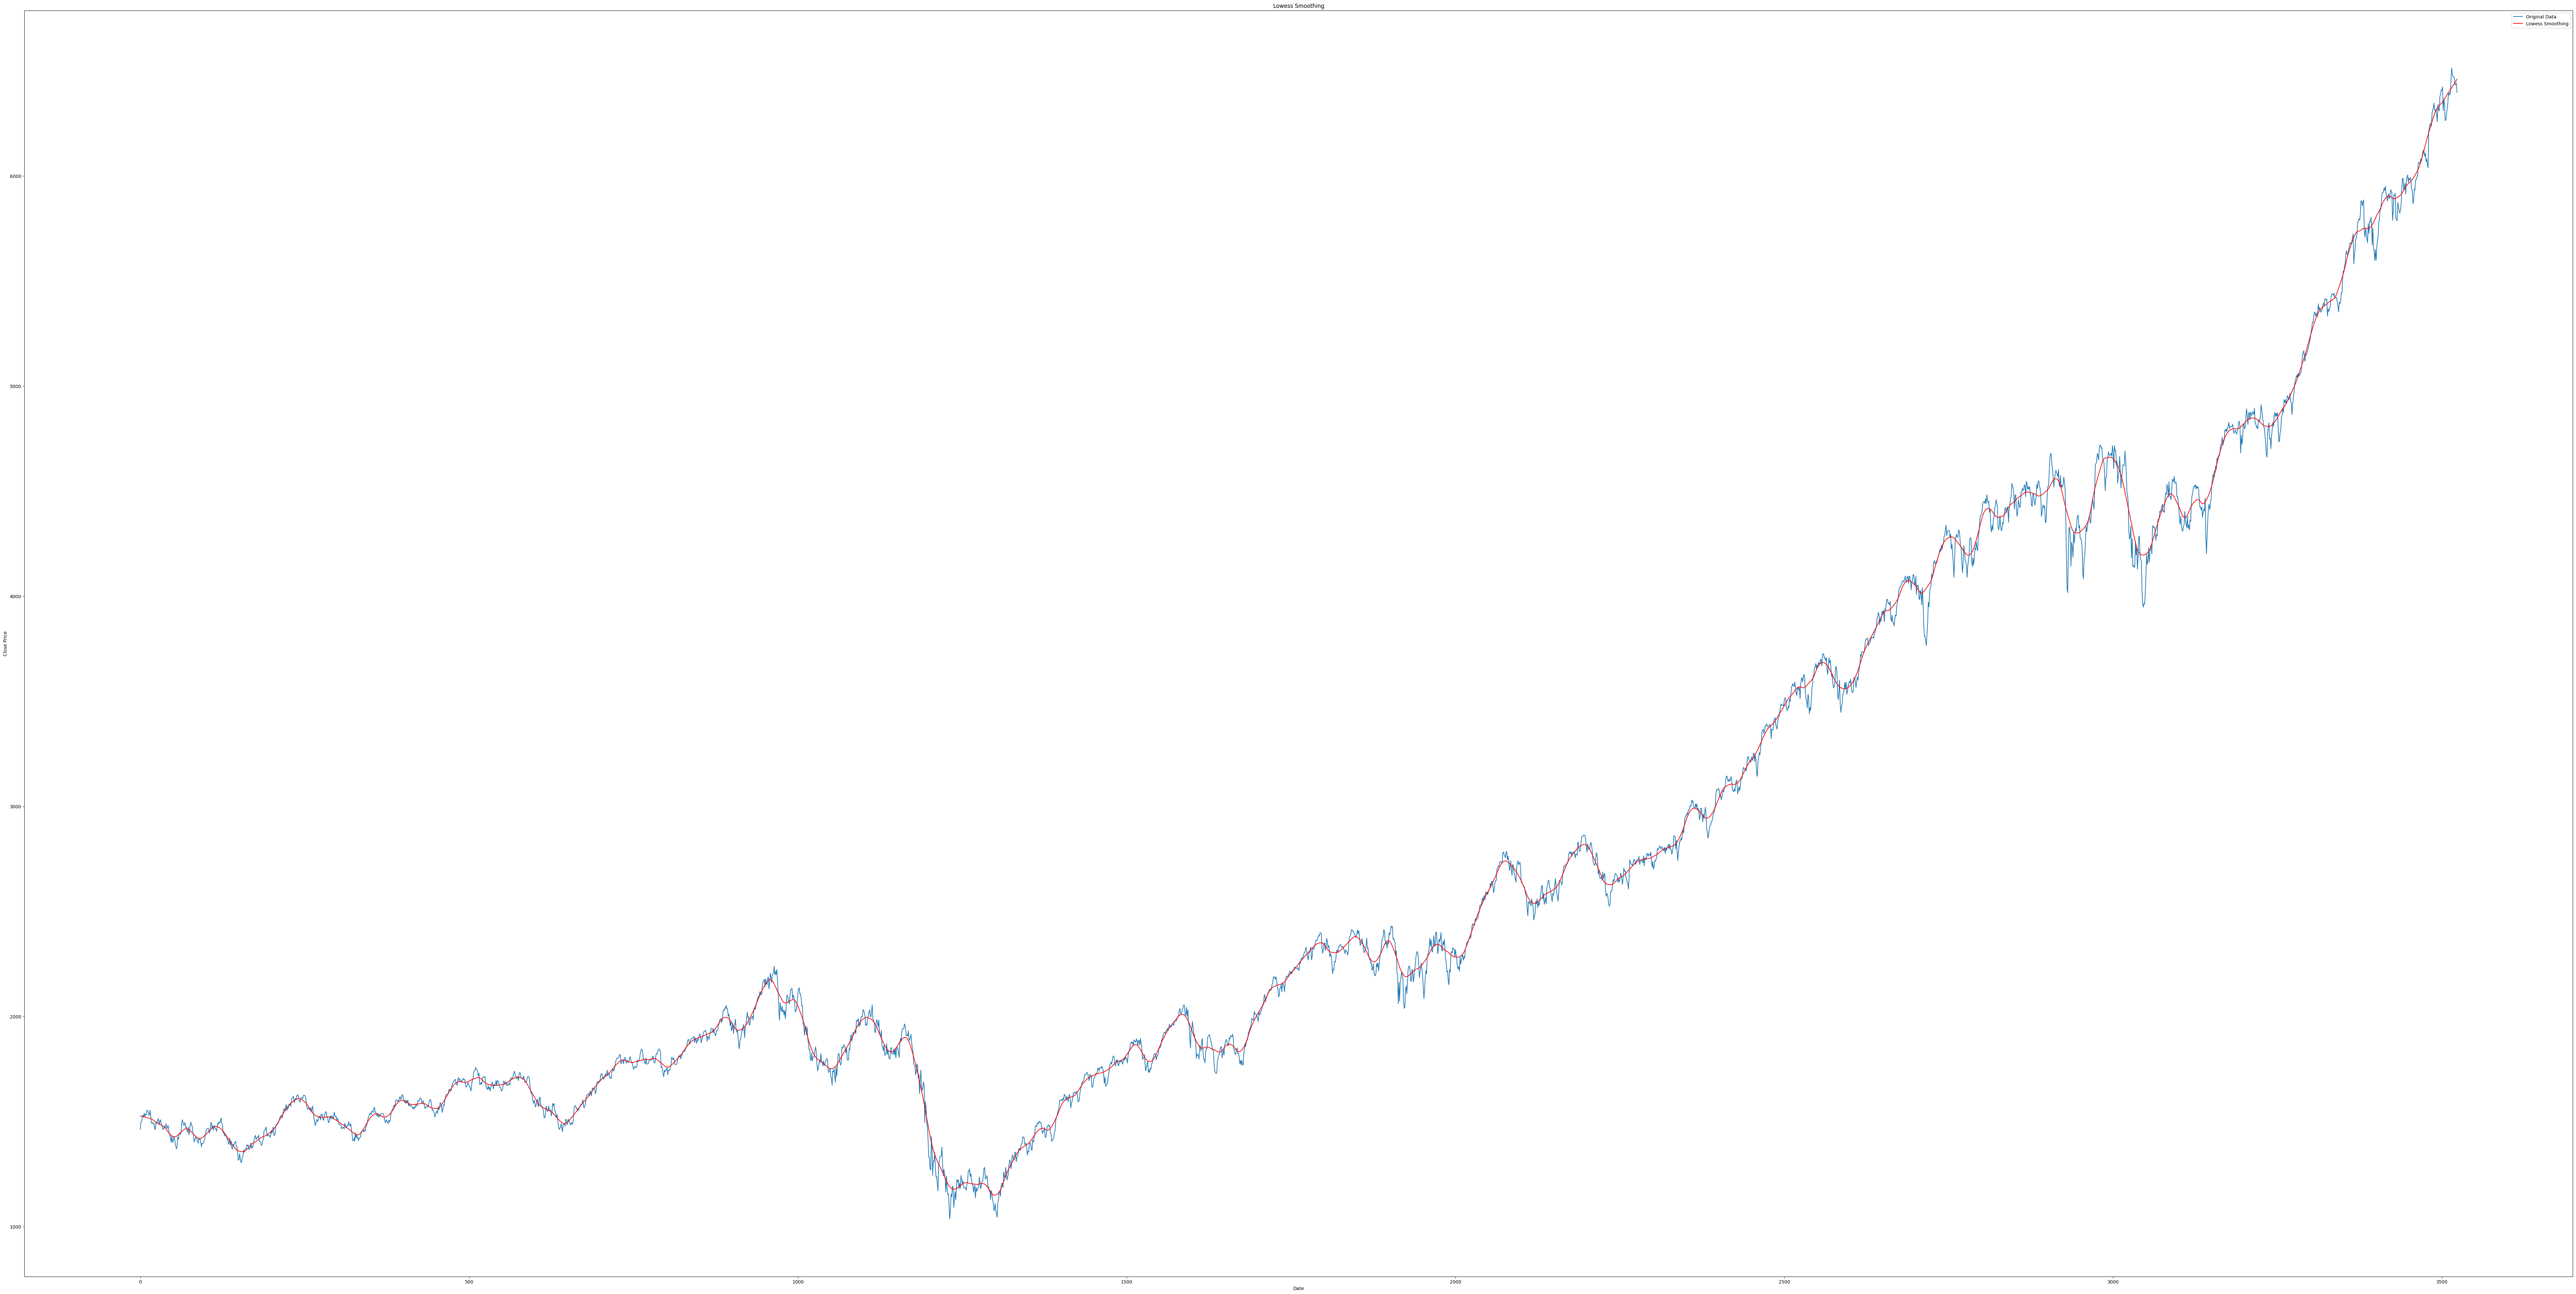

In [21]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.figure(figsize=(100, 50))

df = data_copy.copy()
# Apply Lowess
lowess = sm.nonparametric.lowess
df['LOWESS'] = lowess(df['close'], df.index, frac=0.01)[:, 1]

# Plot the original and smoothed data

plt.plot(df['close'], label='Original Data')
plt.plot(df['LOWESS'], label='Lowess Smoothing', color='red')
plt.legend()
plt.title('Lowess Smoothing')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## data testing

In [22]:
#data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup = pd.read_csv('data-china-from2018-test/000001.SS_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup_copy = data_backup.copy()

In [23]:
X_test, y_test = create_dataset(data_backup[['close']].to_numpy(), time_step=period, output_step=output_step)

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions_test = np.array([seasonal_decompose(X_test[i], model='additive', period=14) for i in range(X_test.shape[0])])
seasons_test = np.array([decompositions_test[i].seasonal for i in range(decompositions_test.shape[0])])

In [25]:
from talib import RSI

rsi_test = np.array([ RSI(X_test[i]) for i in range(X_test.shape[0]) ])

In [26]:
rsi_test.shape

(1547, 60)

In [27]:
import statsmodels.api as sm

smoothing_lowess_test = sm.nonparametric.lowess
lowess_test = np.array([ smoothing_lowess_test(X_test[i], range(60), frac=0.1)[:, 1] for i in range(X_test.shape[0]) ])

In [28]:
lowess_cropped_test = list()
seasons_cropped_test = list()
rsi_dropna_test = list()

for _lowess in lowess_test:
    lowess_cropped_test.append(_lowess[rsi_period:])

for _season in seasons_test:
    seasons_cropped_test.append(_season[rsi_period:])

for _rsi in rsi_test:
    rsi_dropna_test.append(_rsi[rsi_period:])

lowess_cropped_test = np.array(lowess_cropped_test)
seasons_cropped_test = np.array(seasons_cropped_test)
rsi_dropna_test = np.array(rsi_dropna_test)

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler_lowess_test = list(MinMaxScaler() for i in range(lowess_cropped_test.shape[0]))
lowess_scaled_test = list()

scaler_seasonal_test = list(MinMaxScaler() for i in range(seasons_cropped_test.shape[0]))
seasons_scaled_test = list()

scaler_rsi_test = list(MinMaxScaler() for i in range(rsi_dropna_test.shape[0]))
rsi_scaled_test = list()

for i in range(lowess_cropped_test.shape[0]):
    lowess_scaled_test.append(scaler_lowess_test[i].fit_transform(lowess_cropped_test[i].reshape(-1,1)))

for i in range(seasons_cropped_test.shape[0]):
    seasons_scaled_test.append(scaler_seasonal_test[i].fit_transform(seasons_cropped_test[i].reshape(-1,1)))

for i in range(rsi_dropna_test.shape[0]):
    rsi_scaled_test.append(scaler_rsi_test[i].fit_transform(rsi_dropna_test[i].reshape(-1,1)))

lowess_scaled_test = np.array(lowess_scaled_test)
seasons_scaled_test = np.array(seasons_scaled_test)
rsi_scaled_test = np.array(rsi_scaled_test)

In [30]:
X_input_test = list()
#y_input = list()

for lowess, season, rsi in zip(lowess_scaled_test, seasons_scaled_test, rsi_scaled_test):
    X_input_test.append(np.hstack((lowess, season, rsi)))
    #y_input.append(lowess[-y.shape[1]:])

X_input_test = np.array(X_input_test)
#y_input = np.array(y_input)

In [32]:
# Prepare reference y_test
test_input = np.array([np.concatenate((X_test[i], y_test[i]), axis=0) for i in range(X_test.shape[0])])

decompose_test_input = np.array([seasonal_decompose(test_input[i], model='additive', period=14) for i in range(X_test.shape[0])])
trends_test_input = np.array([decompose_test_input[i].trend for i in range(decompose_test_input.shape[0])])

trends_test_input_dropna = list()
for trend in trends_test_input:
    trends_test_input_dropna.append(trend[~np.isnan(trend)])

trends_test_input_dropna = np.array(trends_test_input_dropna)

y_input = list()
for trend in trends_test_input_dropna:
    y_input.append(trend[trend.shape[0]-7:])

y_input = np.array(y_input)

In [31]:
lowess_predictions_test = list()

for j in range(X_input_test.shape[0]):
    if (j+1) % 100 == 0:
        print(j+1)
        
    lowess_predictions_test.append(
        scaler_lowess_test[j].inverse_transform(
            functional_pipeline.predict(X_input_test[j].reshape(lowess_scaled_test[j].shape[1], input_period, num_features), verbose=0)[0].reshape(1,output_step)
        )
    )

lowess_predictions_test = np.array(lowess_predictions_test)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [33]:
# Logistic transformation
def logistic_transform(r2):
    return round(1 / (1 + np.exp(-r2)),2)
        
def report_score(outputs):
    from sklearn.metrics import r2_score
    
    pred, y = outputs
    
    try:
        assert pred.shape[2] == output_step
        assert y.shape[1] == output_step

        _pred = pred.reshape(-1, output_step)
        _y = y.reshape(-1, output_step)
    
        res = list()
        for i in range(_pred.shape[0]):
            res.append(r2_score(_y[i], _pred[i]))

        res = np.array(res)
    
        return {
            'mean_score': np.mean(res),
            'max_score': res.max(),
            'min_score': res.min(),
            'logistic_score': logistic_transform(np.mean(res))
        }
    except:
        print("Array shapes don't match")

In [35]:
report_score((lowess_predictions_test, y_input))

{'mean_score': -105.82343370592703,
 'max_score': 0.8696524776178833,
 'min_score': -4698.249579750032,
 'logistic_score': 0.0}

In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

t = 0

plt.plot(data_backup.index[t+53:t+60], lowess_predictions_test[0][0], color='blue')
plt.plot(data_backup.index[t+8:t+54], lowess_cropped_test[0], color='black')
plt.plot(data_backup.index[t:t+60], data_backup['close'].iloc[t:t+60], color='red')

NameError: name 'data_backup' is not defined

<Figure size 5000x4000 with 0 Axes>